# Introduction à l'apprentissage par renforcement
# TP 1 - les manchots multi-bras

1/4 de la note finale est liée à la mise en forme : 

* pensez à nettoyer les outputs inutiles (installation, messages de débuggage, ...)
* soignez vos figures : les axes sont-ils faciles à comprendre ? L'échelle est adaptée ? 
* commentez vos résultats : vous attendiez-vous à les avoir ? Est-ce étonnant ? Faites le lien avec la théorie.

Ce TP reprend l'exemple d'un médecin et de ses vaccins. Vous allez comparer plusieurs stratégies et trouver celle optimale.
Un TP se fait seul ou en binôme. Aucun groupe de plus de 2 personnes. 

Vous allez rendre le TP depuis un lien GitHub avec ce notebook mais une version du rapport exportée en PDF & HTML. 

In [4]:
! pip install matplotlib tqdm numpy ipympl opencv-python
!jupyter labextension install @jupyter-widgets/jupyterlab-manager
!jupyter labextension install jupyter-matplotlib

In [5]:
%load_ext autoreload
%autoreload 2
%matplotlib inline 

import typing as t
import math
import torch
import numpy as np
from tqdm.auto import trange, tqdm
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import cv2
from IPython.display import display, clear_output

torch.random.manual_seed(0)

K = 5 # num arms

# Présentation du problème

In [6]:
class ArmBernoulli:
    def __init__(self, p: float):
        """
        Vaccine treatment following a Bernoulli law (mean is p and variance is p(1-p)
        Args:
             p (float): mean parameter
             
        >>> torch.random.manual_seed(random_state)        
        >>> arm = ArmBernoulli(0.5)
        >>> arm.sample(5)
        tensor([ True, False,  True,  True,  True])
        """
        self.immunity_rate = p

    def sample(self, n: int = 1):
        return torch.rand(n) < self.immunity_rate
    
    def __repr__(self):
        return f'<ArmBernoulli p={self.immunity_rate}' 

def generate_arms(num_arms: int):
    means = torch.rand(K)
    MAB = [ArmBernoulli(m) for m in means]
    assert MAB[0].immunity_rate == means[0]
    assert (MAB[0].sample(10) <= 1).all() and (MAB[0].sample(10) >= 0).all() 
    return MAB

MAB = generate_arms(K)

Ce TP reprend l'exemple du médecin présenté en cours.


**Q1. Créez une fonction pour trouver $\mu^*$ à partir d'un `MAB`. Comment est définie la récompense $R_k$ ? Que représente concrètement le regret dans le contexte de ce TP ?**

In [7]:
#set random_state to 0
torch.manual_seed(0)

MAB = generate_arms(K)
best_arm = max(MAB, key=lambda MAB: MAB.immunity_rate)
arms_immunity_rate = [arm.immunity_rate.item() for arm in MAB]

print(f'Immunty_rate for random_state == 0 is : {arms_immunity_rate}')
print('----')
print(f'Best vaccin is : {best_arm}')

Immunty_rate for random_state == 0 is : [0.49625658988952637, 0.7682217955589294, 0.08847743272781372, 0.13203048706054688, 0.30742281675338745]
----
Best vaccin is : <ArmBernoulli p=0.7682217955589294


**Définition récompense R_k**  
La récompense R_k est définit par une loi de Bernouilli.

**Représentation du regret**  
Le regret représente la différence de personne qui aurait du être immunisé après l'injection du vaccin mais qui aurait du l'être

**Note importante :** pour la suite, les résultats seront généralement réalisés avec 100 initialisations différentes du MAB (tous les MAB ont 5 vaccins mais des taux d'immunistation différent) pour réduire le bruit de simulation. Concrètement, on exécutera au moins 100x `generate_arms`.

# I. Cas classique des bandits manchots 

## I.a. Solution Gloutonne

Le médecin fonctionne sur deux phases :

1. **Exploration :** Le médecin calcule le taux d'immunisation empirique sur les N premiers patients en administrant le même nombre de fois chaque vaccin :

$$\hat{\mu_i}[0\rightarrow N] = \frac{1}{T_i} \sum_{k=0}^{N-1} \chi_{v_k,i}R_k,$$

avec $T_i = \sum_{k=0}^{N-1} \chi_{v_k,i}$.


2. **Exploitation :** Le vaccin $v_i = \arg\max_j \hat{\mu_j}[0\rightarrow N]$ est utilisé pour les M patients suivants.

**Q2. Implémentez cette solution avec N = 50 et M = 500 et testez-la avec 100 MAB. On souhaite savoir si vous trouvez le vaccin optimal à l'issue d'une phase d'exploration. Quelle est l'espérance empirique de cette variable ? Et son écart-type ? Calculez de même l'espérance et l'écart-type du regret sur vos 100 simulations.**

Pour rappel, le regret est défini par :

$$r_n = n\mu^* - \sum_{k=0}^{n-1} R_k$$

**Attention :** $n$ est le nombre total de patients, donc ici $N + M$.

In [9]:
#Déclaration des constantes
N = 50
M = 500
number_MAB = 100

In [134]:
def getBestVaccin(MAB):
    best_arm = max(MAB, key=lambda MAB: MAB.immunity_rate)
    best_index = MAB.index(best_arm)
    return best_index

def getBestResult(vac_results):
    return vac_results.index(max(vac_results))

def Vaccin_arms(MAB, n):
    patient = []
    for i in range(len(MAB)):
        vaccins = MAB[i].sample(n)
        vaccins = [1 if vaccin else 0 for vaccin in vaccins]
        patient += (vaccins)
    return patient

def Exploration(MAB, n=N):  #return [1,0,...],
    Ti = n // len(MAB)  #Distribution uniforme
    vaccins = Vaccin_arms(MAB, Ti)
    vac_results = []
    for i in range(len(MAB)):
        sum = 0
        for j in range(Ti):
            ind = i * Ti + j
            sum += vaccins[ind]
        vac_results.append(sum / Ti)
    return vac_results

def Exploitation(MAB, vac_results, m=M):  #return [1,0 ...], for best vaccin
    arg_max = getBestResult(vac_results)
    vaccins = MAB[arg_max].sample(m)
    vaccins = [1 if vaccin else 0 for vaccin in vaccins]
    return vaccins

def gloutonne(number_MAB=100):
    exploration_var = []
    regret = []
    for _ in range(number_MAB):
        MAB = generate_arms(K)
        exploration = Exploration(MAB, N)
        best_arm = getBestVaccin(MAB)
        if (best_arm == getBestResult(exploration)):
            exploration_var.append(1)
        else:
            exploration_var.append(0)    

        exploitation = Exploitation(MAB, exploration, M)
        Ti = N // len(MAB)
        r_N = (N + M) * MAB[best_arm].immunity_rate - ((exploration[best_arm] * Ti) + sum(exploitation))
        regret.append(r_N)
    return exploration_var, regret

exploration_var, regret = gloutonne(number_MAB)
print(f'Espérence empirique de l\'exploration : {np.mean(exploration_var)}')
print(f'Ecart-type de l\'exploration : {np.std(exploration_var)}')
print(f'Espérence empirique du regret : {np.mean(regret)}')
print(f'Ecart-type du regret : {np.std(regret)}')

Espérence empirique de l'exploration : 0.74
Ecart-type de l'exploration : 0.4386342439892262
Espérence empirique du regret : 46.02141571044922
Ecart-type du regret : 36.8586311340332


**Q3. On étudie maintenant l'influence de la taille du training set $N$. On considère que N+M est une constante, puis on fait varier N entre K et M. Calculez le regret pour ces différentes tailles du training set  différents MAB et representez le regret moyen, le regret min et max (vous devriez trouver une courbe en U ou en V pour le regret moyen). Quelle est la taille optimale du training set ?**

In [77]:
# Constantes
n_total = N + M

def gloutonne_2():
    regret = []
    n = K #5
    m = n_total - n #545
    MAB = generate_arms(K)
    while n <= m:
        exploration = Exploration(MAB, n)
        exploitation = Exploitation(MAB, exploration, m)
        
        #regret
        Ti = n // len(MAB)
        best_arm = getBestVaccin(MAB) 
        r_N = (n + m) * MAB[best_arm].immunity_rate - ((exploration[best_arm] * Ti) + sum(exploitation))
        regret.append(r_N.item())
        n = n + K
        m = m - K
    return regret

import matplotlib.pyplot as plt

def plot_regret(regret):
    means = [np.mean(regret)] * len(regret)

    plt.figure(figsize=(10, 6))
    plt.plot(np.arange(0, len(regret)*K, K), regret, marker='o', linestyle='-', color='b')
    plt.plot(np.arange(0, len(regret)*K, K), means, linestyle='-', color='r')

    plt.xlabel('Valeur de N')
    plt.ylabel('Regret')
    plt.title('Courbe du Regret')

    plt.grid(True)
    plt.show()

In [87]:
regret_v2 = gloutonne_2()

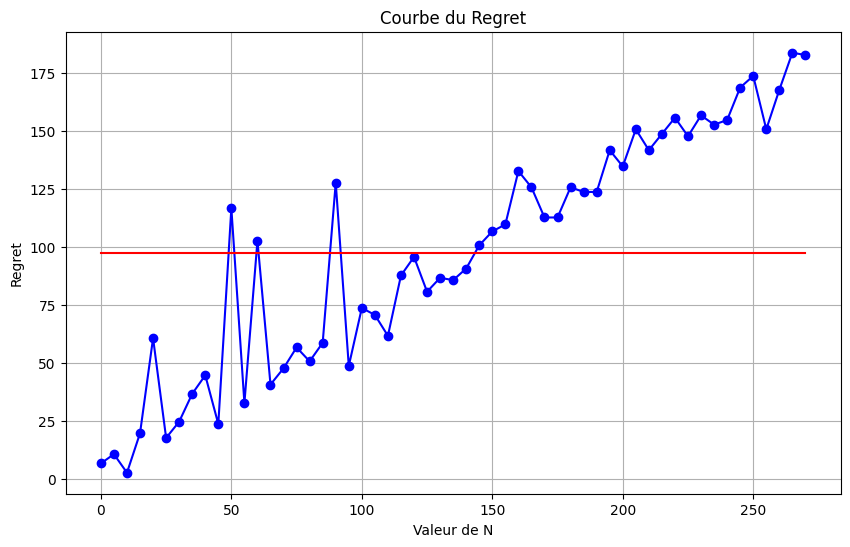

regret min : 2.546234130859375  | regret max : 183.54623413085938  | regret moyen : 97.12805231267755
La taille optimal du training set N est : 10


In [88]:
plot_regret(regret_v2)
print('regret min :', min(regret_v2), ' | regret max :', max(regret_v2), ' | regret moyen :', np.mean(regret_v2))
print('La taille optimal du training set N est :', np.argmin(regret_v2) * K)

**Q4. On propose d'améliorer l'algorithme précédant en mettant à jour les taux d'immunisation empiriques $\hat{\mu}_i$ pendant la phase d'exploitation (algorithme *greedy*). Concrètement, à chaque nouvel patient, on lui administre le meilleur vaccin selon les stats. Notez vous une amélioration du regret ? Proposez un exemple où les taux d'immunisation du MAB ne changent rien.** 

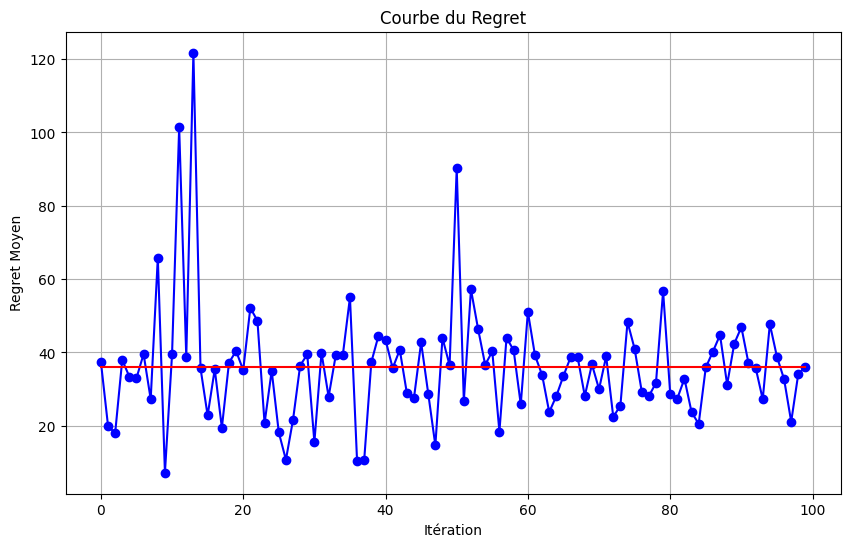

Espérence empirique du regret : 36.075138092041016
Ecart-type du regret : 16.25272560119629


In [94]:
def Exploitation_greedy(MAB, immunity_rate):
    vaccins = []
    Ti = N // len(MAB)
    hist = [Ti] * len(MAB)  # size -> 5
    for _ in range(M):
        best_arm = getBestResult(immunity_rate)
        arm = MAB[best_arm].sample(1).item()
        hist[best_arm] += 1
        immunity_rate[best_arm] = (immunity_rate[best_arm] * (hist[best_arm] - 1) + arm) / hist[best_arm]
        vaccins.append(arm)
    vaccins = [1 if vaccin else 0 for vaccin in vaccins]
    return vaccins

def gloutonne_greedy(number_MAB=100):
    regret = []
    for _ in range(number_MAB):
        MAB = generate_arms(5)
        exploration = Exploration(MAB)
        best_arm = getBestVaccin(MAB)   

        exploitation = Exploitation_greedy(MAB, exploration)
        Ti = N // len(MAB)
        r_N = (N + M) * MAB[best_arm].immunity_rate - ((exploration[best_arm] * Ti) + sum(exploitation))
        regret.append(r_N)
    return regret

def plot_regret_greedy(regret):
    means = [np.mean(regret)] * len(regret)

    plt.figure(figsize=(10, 6))
    plt.plot(np.arange(0, len(regret), 1), regret, marker='o', linestyle='-', color='b')
    plt.plot(np.arange(0, len(regret),1), means, linestyle='-', color='r')

    plt.xlabel('Itération')
    plt.ylabel('Regret Moyen')
    plt.title('Courbe du Regret')

    plt.grid(True)
    plt.show()

regret_greedy = gloutonne_greedy(number_MAB)
plot_regret_greedy(regret_greedy)
print(f'Espérence empirique du regret : {np.mean(regret_greedy)}')
print(f'Ecart-type du regret : {np.std(regret_greedy)}')


**Réponse**  
La figure montre le résultats sur 100 itérations contenant tous 5 MAB aléatoires.  
Nous remarquons que l'écart-type du regret diminue drastiquement.  
Quant à la moyenne du regret, elle ne diminue que légèrement (\< 10). Les résultats sont donc dans l'ensemble meilleur avec cette algorithme (greedy).  

Cette mise à jour ne change rien dans le cadre où le meilleur vaccin théorique est trouvé dès le début (à la première itération).

**Q5. Nouvelle amélioration : à chaque nouveau patient, on choisit si on lui administre le meilleur vaccin avec une probabilité $\epsilon$ ou un vaccin aléatoire ($p=1-\epsilon$). Vérifiez si vous obtenez un meilleur résultat avec N = 0 ou N > 0. À votre avis, à quoi sert $\epsilon$ ?** 

In [12]:
#Constantes
eps = 0.9

def Exploitation_proba(MAB, immunity_rate, n=N, m=M):
    vaccins = []
    Ti = n // len(MAB)
    hist = [Ti] * len(MAB)
    for _ in range(m):
        if (torch.rand(1) > eps):
            best_arm = torch.randint(0, len(MAB), (1,)).item()
        else:
            best_arm = getBestResult(immunity_rate)
        arm = MAB[best_arm].sample(1).item()
        hist[best_arm] += 1
        immunity_rate[best_arm] = (immunity_rate[best_arm] * (hist[best_arm] - 1) + arm) / hist[best_arm]
        vaccins.append(arm)
    vaccins = [1 if vaccin else 0 for vaccin in vaccins]
    return vaccins

def gloutonne_proba(number_MAB=100, n=N, m=M):
    regret = []
    for _ in range(number_MAB):
        MAB = generate_arms(K)
        if (n == 0):
            exploration = [0] * len(MAB)
        else:
            exploration = Exploration(MAB, n)
        
        best_arm = getBestVaccin(MAB)
        arg_max = getBestResult(exploration)
        exploitation = Exploitation_proba(MAB, exploration, n=n)
        Ti = n // len(MAB)
        r_N = (n + m) * MAB[best_arm].immunity_rate - ((exploration[arg_max] * Ti) + sum(exploitation))
        regret.append(r_N)
    return regret

regret_eps= gloutonne_proba(number_MAB, n=N)
regret_eps_0 = gloutonne_proba(number_MAB, n=0)
print(f'Moyenne du regret pour N > 0 : {np.mean(regret_eps)}')
print(f'Moyenne du regret pour N = 0 : {np.mean(regret_eps_0)}')

Moyenne du regret pour N > 0 : 53.545475006103516
Moyenne du regret pour N = 0 : 39.8148307800293


**Réponse**  

Nous obtenons de meilleurs résulats avec N = 0. Cependant, le regret est moins bon avec l'amélioration qu'avec la méthode greedy classique  

Epsilon permet de tester des d'autres vaccins, afin de ne pas être bloqué sur un maximum local (recherche ailleurs), c'est à dire, il établie une recherche aléatoire pour trouver le le bras avec la meilleure immunity rate.

## I.b. Borne inférieure de Lai & Robbins [Lai et Robbins, 1985]

Lai et Robbins [Lai et Robbins, 1985] considère une classe d'algorithmes $\pi$ pour résoudre ce type de problèmes.

Ils ont trouvé une borne inférieure sur les récompenses cumulées en valeur asymptotique :

$$\lim_{n\rightarrow \infty} \inf_{\pi} \frac{\sum_{k=0}^{n-1} R_k}{\log n} \geq \sum_{i~\text{tel que}~\mu_i \lt \mu^*} \frac{\mu^∗−\mu_i}{\text{KL}(\mu_i, \mu^*)}  :=C(\mu)$$
 
 avec $\text{KL}(x, y) = x \log(x/y) + (1 − x) \log((1 − x)/(1 − y))$ (distance de Kullback-Leibler) et  $\sum_{k=0}^{n-1} R_k$ la récompense obtenue sur $n$ patients.
 
 
**Q6. Justifiez pourquoi on peut en déduire que le regret d'un algorithme raisonnable sera au pire logarithmique.**

**Réponse**  
La borne inférieure de Lai et Robbins montre que la récompense cumulée d'un algorithme efficace suit asymptotiquement une croissance proportionnelle à $log(n)$ :

$$
\lim_{n \to \infty} \inf_{\pi} \frac{\sum_{k=0}^{n-1} R_k}{\log n} \geq C(\mu)
$$

Le regret $R(n)$ est défini comme la différence entre la récompense maximale que l'on pourrait obtenir en jouant toujours le meilleur bras (celui avec la plus grande espérance, $\mu^*$) et la récompense effectivement obtenue par l'algorithme. Autrement dit :

$$R(n) = n\mu^* - \mathbb{E}\left[\sum_{k=0}^{n-1} R_k\right]$$

En utilisant la borne inférieure sur la somme des récompenses obtenues $\sum_{k=0}^{n-1} R_k$, on peut en déduire que :

$$R(n) \geq n\mu * \, - \,\, C(\mu){\log n}$$

Cela signifie que, pour un algorithme raisonnable, le regret ne peut pas croître plus vite qu'une fonction logarithmique en $n$, c'est-à-dire que $R(n) = O(\log n)$ dans le pire des cas. En d'autres termes, tout algorithme efficace dans ce cadre aura un regret au plus logarithmique.

Ainsi, la borne inférieure de Lai et Robbins, en montrant que la récompense cumulée doit croître au moins comme $C(\mu) \log n$, implique que le regret d'un algorithme raisonnable sera également logarithmique dans $n$. Un algorithme "raisonnable" ne pourra donc pas avoir un regret asymptotiquement pire que $O(\log n)$.

**Q7. Tracez le regret issu de la borne de Lai & Robbins et comparez le au regret obtenu avec l'algorithme glouton.**

In [13]:
#Lay & Robbins
def kl_divergence(x, y):
    return x * np.log(x / y) + (1 - x) * np.log((1 - x) / (1 - y))

def lower_bound(n, immunity_rate, mu_star):
    C_mu = 0
    for mu_i in immunity_rate:
        if mu_i < mu_star:
            C_mu += (mu_star - mu_i) / kl_divergence(mu_i, mu_star)
    return C_mu * np.log(n)

def lai_robbins_regret(n, C_mu, mu_star):
    return n * mu_star - C_mu

def lai_robbins(MAB, n):
    immunity_rate = [arm.immunity_rate.item() for arm in MAB]
    mu_star = max(immunity_rate)
    C_mu = lower_bound(n, immunity_rate, mu_star)
    regret = lai_robbins_regret(n+1, C_mu, mu_star)
    return C_mu, regret

def Exploitation_MAB(MAB, vac_results, m=M, n=N):
    arg_max = getBestResult(vac_results)
    best_arm = getBestVaccin(MAB)
    Ti = n // len(MAB)
    
    regrets = []
    rewards = (vac_results[arg_max] * Ti)
    for m_i in range(m):
        vaccins = MAB[arg_max].sample(1)
        rewards += vaccins
    
        regret = (n + m_i) * MAB[best_arm].immunity_rate - rewards
        regrets.append(regret.item())
    return regrets

def gloutonne_MAB(MAB, n=N, m=M):
    exploration = Exploration(MAB, N) 
    regrets = Exploitation_MAB(MAB, exploration, m=m, n=n)
    return regrets

#Comparaison
def compare():
    MAB = generate_arms(K)
    regrets_lay_robbins = []
    C_mus = []

    for i in range(1, M+1):
        C_mu, regret_lay_robbins = lai_robbins(MAB, i)
        C_mus.append(C_mu)
        regrets_lay_robbins.append(regret_lay_robbins)
    regrets_gloutonne = gloutonne_MAB(MAB, n=N, m=M)

    return C_mus, regrets_lay_robbins, regrets_gloutonne

def plot_compare(C_mus, regret_lay_robbins, regrets_gloutonne):
    plt.figure(figsize=(10, 6))
    plt.plot((range(1, M+1)), C_mus, linestyle='-', label='C_mu')
    plt.plot((range(1, M+1)), regret_lay_robbins, linestyle='-', label='Regret Lay & Robbins')
    plt.plot((range(1, M+1)), regrets_gloutonne, linestyle='-', label='Regret Gloutonne')
    plt.legend()
    plt.title('Comparaison du regret Lay & Robbins et Gloutonne')
    plt.grid(True)
    plt.autoscale()

    plt.savefig("figures/Lay_Robbins.png")
    plt.show()

In [14]:
C_mus, regrets_lay_robbins, regrets_gloutonne = compare()

Moyenne du regret de l'algorithme glouton: 30.702554962158203
Moyenne du regret de l'algorithme Lay & Robbins: 207.9339983613193


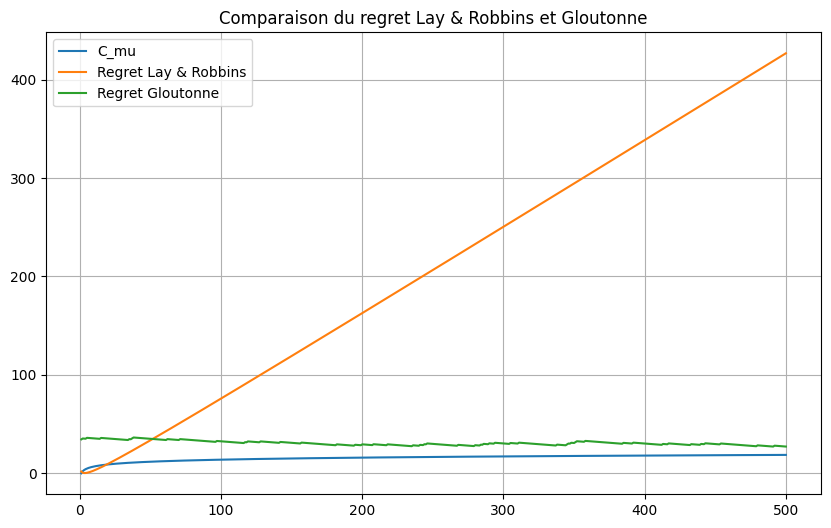

In [16]:
print(f'Moyenne du regret de l\'algorithme glouton: {np.mean(regrets_gloutonne)}')
print(f'Moyenne du regret de l\'algorithme Lay & Robbins: {np.mean(regrets_lay_robbins)}')
plot_compare(C_mus, regrets_lay_robbins, regrets_gloutonne)

**Réponse**  
Nous constatons que l'algorithme glouton obtient de meilleur résultat que l'algorithme Lay & Robbins.

## I.c. Upper Confidence Bounds

Cet algorithme améliore la version précédente en ajoutant un biais lié à la fréquentation de chaque vaccin :

$$
\bar{\mu}_i = \hat{\mu}_i + \sqrt{\frac{C\log{n}}{T_i}}
$$,

avec $C=2$.


**Q8. Implémentez la modification de cet algorithme. Observez un intérêt à conserver $N > 0$ ? Et $\epsilon < 1$ ? Expliquez pourquoi.**

Dans la suite, on prendra $N = 0$ et $\epsilon = 1$.

In [130]:
def ApplyBias_GetBestVaccin(vac_results, hist, n, C=2):
    rewards_b = np.zeros(K)
    for i in range(K):
        if (hist[i] != 0):
            rewards_b[i] = vac_results[i] / hist[i] + math.sqrt(C * math.log(n) / hist[i])
        else:
            rewards_b[i] = np.inf
    return np.argmax(rewards_b)

def Exploitation_UCB(MAB, immunity_rate, n, m, eps, C=2):
    Ti = n // K
    hist = [Ti] * K
    rewards = [immunity_rate[i] * hist[i] for i in range(K)]
    for m_i in range(1, m+1):
        if (torch.rand(1) > eps):
            best_arm = torch.randint(0, len(MAB), (1,)).item()
        else:
            best_arm = ApplyBias_GetBestVaccin(rewards, hist, n+m_i, C=C)
        arm = MAB[best_arm].sample(1).item()
        hist[best_arm] += 1
        rewards[best_arm] = rewards[best_arm] + arm
    return np.sum(rewards)

def UCB(MABs, n, m, eps, C=2):
    regret = []
    for MAB in MABs:
        #MAB = generate_arms(K)
        if (n == 0):
            exploration = [0] * len(MAB)
        else:
            exploration = Exploration(MAB, n)
        
        best_arm = getBestVaccin(MAB)
        exploitation = Exploitation_UCB(MAB, exploration, n, m, eps, C=C)
        r_N = (n + m) * MAB[best_arm].immunity_rate - exploitation
        regret.append(r_N)
    return regret

In [180]:
def multi_plot_regret(total_regrets):

    colors = ['b', 'r', 'g', 'y']
    labels = ['epsilon = 0.2', 'epsilon = 0.5', 'epsilon = 0.8', 'epsilon = 1']

    plt.figure(figsize=(15, 8))

    for i in range(len(total_regrets)):
        plt.plot(np.arange(0, M+N, K),total_regrets[i], marker='x', linestyle='--', color=colors[i], label=labels[i])

    plt.legend()

    plt.xlabel('Taille de N')
    plt.ylabel('Regret')
    plt.title('Courbe du Regret en fonction de N et epsilon')

    plt.grid(True)
    plt.show()

In [181]:
def UCB_regret_test():
    eps = [0.2, 0.5, 0.8, 1]

    regrets = [[] for i in range(len(eps))]
    n_total = N + M
    
    MABs = [generate_arms(K) for i in range(100)]

    for n in range(0, 200, K):
        for i in range(len(eps)):
            regret = UCB(MABs, n, n_total-n, eps[i], C=2)
            regrets[i].append(np.mean(regret))
    
    return regrets

UCB_regret = UCB_regret_test()

KeyboardInterrupt: 

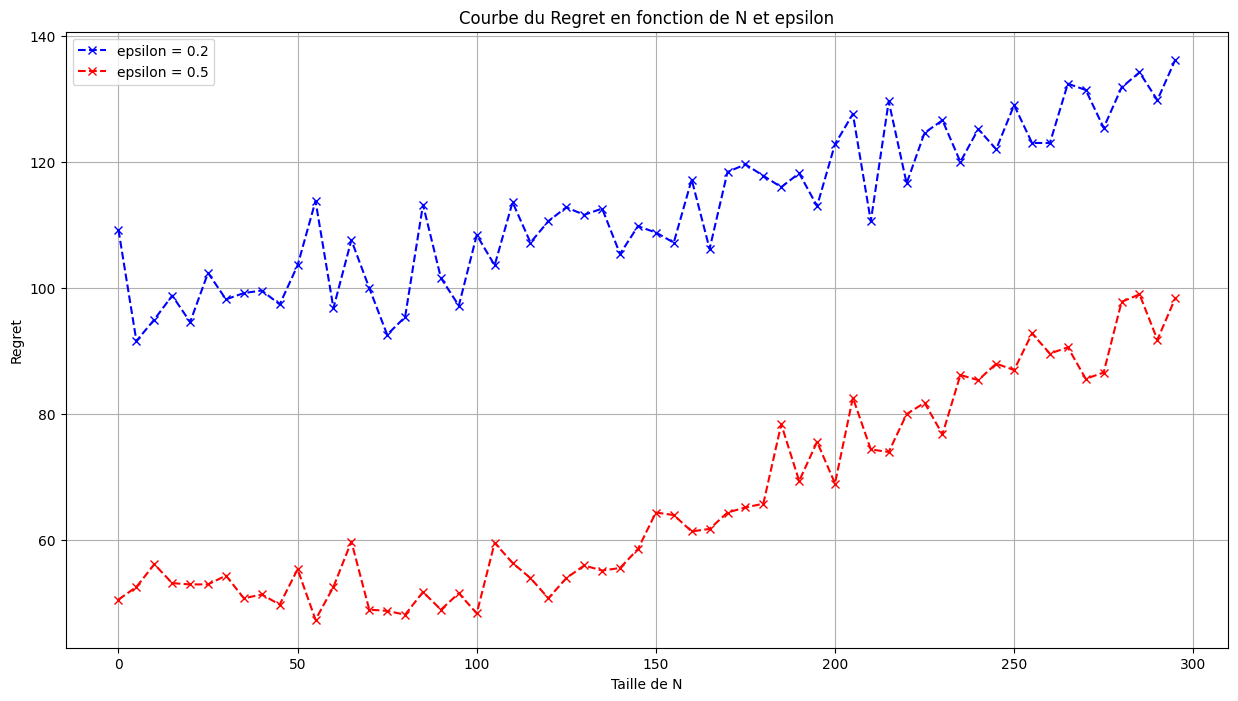

In [179]:
multi_plot_regret(UCB_regret)

**Réponse**  
N > 0 indique la taille du training set N (nombre de vaccins dans la phase d'exploration).  
Ici, en appliquant l'algorithme UCB, les vacins les moins représentés sont forcés à être testé, ce qui rend inutile la phase d'exploration (les informations des différents vaccins sont constamment mis à jour).  
$\epsilon < 1$ indique que lors de la phase d'exploitation, il y a une chance $\epsilon$ de prendre un vaccin aléatoirement, ce qui fait que les différents vaccins peuvent être tous être sélectionnés.  
Cependant, comme expliqué, l'algorithme UCB applique déjà ces procédés. N > 0 et $\epsilon < 1$ n'ont pas d'intéret à être conservés.

**Q9. Tracez sous la forme d'une animation l'évolution des taux d'immunisation empirique (fig. de gauche) et l'évolution du regret (fig. droite). Dans la figure de gauche, vous representerez $\bar{\mu}_i$ et $\hat{\mu}_i$ pour chaque vaccin.**

In [182]:
def ApplyBias_GetBestVaccin_figure(vac_results, hist, n, C=2):
    rewards_b = []
    for i in range(len(vac_results)):
        if hist[i] != 0:
            bias = vac_results[i] + math.sqrt(C * math.log(n) / hist[i])
        else:
            bias = vac_results[i]
        rewards_b.append(bias)
    index = rewards_b.index(max(rewards_b))
    return rewards_b, index

def Exploitation_proba_figure_animation(MAB, exploration, n, m, eps, C=2):
    vaccins = []
    total_immunity_rate = []
    total_immunity_rate_bias = []
    immunity_rate = exploration.copy()  # Use a copy to avoid references
    regret = []
    Ti = n // len(MAB)
    hist = [Ti] * len(MAB)
    best_vaccin = getBestVaccin(MAB)
    for m_i in range(m):
        total_immunity_rate.append(immunity_rate.copy())
        if torch.rand(1).item() > eps:
            best_arm = torch.randint(0, len(MAB), (1,)).item()
            total_immunity_rate_bias.append(immunity_rate.copy())
        else:
            rewards, best_arm = ApplyBias_GetBestVaccin_figure(immunity_rate, hist, n + m_i, C=C)
            total_immunity_rate_bias.append(rewards)
        arm = MAB[best_arm].sample(1)[0]  # Removed .item(), get first element
        hist[best_arm] += 1
        immunity_rate[best_arm] = (immunity_rate[best_arm] * (hist[best_arm] - 1) + arm) / hist[best_arm]
        vaccins.append(arm)
        r_N = (n + m_i) * MAB[best_vaccin].immunity_rate - ((exploration[best_arm] * Ti) + sum(vaccins))
        regret.append(r_N)
    vaccins = [1 if vaccin else 0 for vaccin in vaccins]
    return regret, total_immunity_rate, total_immunity_rate_bias

def UCB_figure_animation(MABs, n, m, eps, C=2):
    all_regret = []
    all_total_immunity_rate = []
    all_total_immunity_rate_bias = []
    for MAB in MABs:
        if n == 0:
            exploration = [0.0] * len(MAB)
        else:
            exploration = Exploration(MAB, n)
        regret, total_immunity_rate, total_immunity_rate_bias = Exploitation_proba_figure_animation(MAB, exploration, n, m, eps, C=C)
        all_regret.append(regret)
        all_total_immunity_rate.append(total_immunity_rate)
        all_total_immunity_rate_bias.append(total_immunity_rate_bias)
    return all_regret, all_total_immunity_rate, all_total_immunity_rate_bias

In [184]:
# Animation Setup
def create_animation():
    K = 5      
    M = 100   
    N = 50     
    eps = 0.1 
    C = 2   

    # Generate arms
    MABs = [generate_arms(K) for _ in range(1)]

    n_init = 5
    m_init = M + N - n_init
    regrets, total_immunity_rate, total_immunity_rate_bias = UCB_figure_animation(MABs, n_init, m_init, eps, C=C)

    regrets = regrets[0]
    total_immunity_rate = total_immunity_rate[0]
    total_immunity_rate_bias = total_immunity_rate_bias[0]

    fig, (ax_left, ax_right) = plt.subplots(1, 2, figsize=(16, 6))

    x = np.arange(K)
    width = 0.35 

    bars_mu = list(ax_left.bar(x - width/2, [0]*K, width, label=r'$\bar{\mu}_i$'))
    bars_hat_mu = list(ax_left.bar(x + width/2, [0]*K, width, label=r'$\hat{\mu}_i$'))

    ax_left.set_xlim(-0.5, K-0.5)
    ax_left.set_ylim(0, 1) 
    ax_left.set_title("Évolution des taux d'immunisation empirique")
    ax_left.set_xlabel("Vaccin")
    ax_left.set_ylabel("Taux d'immunisation")
    ax_left.set_xticks(x)
    ax_left.set_xticklabels([f'V{k+1}' for k in range(K)])
    ax_left.legend()

    line_regret, = ax_right.plot([], [], color='red', label='Regret')
    ax_right.set_title("Évolution du regret")
    ax_right.set_xlabel("Temps")
    ax_right.set_ylabel("Regret")
    ax_right.set_xlim(0, len(regrets))
    ax_right.set_ylim(0, max(regrets) * 1.1 if len(regrets) > 0 else 1)
    ax_right.legend()

    def update(frame):
        if frame == 0:
            return bars_mu + bars_hat_mu + [line_regret]

        current_mu = total_immunity_rate[:frame]
        mean_mu = np.mean(current_mu, axis=0)
        current_mu_bias = total_immunity_rate_bias[:frame]
        mean_mu_bias = np.mean(current_mu_bias, axis=0)

        for k in range(K):
            bars_mu[k].set_height(mean_mu[k])
            bars_hat_mu[k].set_height(mean_mu_bias[k])

        # Update regret line
        x_regret = np.arange(frame)
        y_regret = regrets[:frame]
        line_regret.set_data(x_regret, y_regret)

        return bars_mu + bars_hat_mu + [line_regret]

    # Create animation
    ani = FuncAnimation(fig, update, frames=len(regrets)+1, blit=True, interval=100, repeat=False)

    # Display animation
    return HTML(ani.to_jshtml())

# Run Animation
animation_html = create_animation()
display(animation_html)

ModuleNotFoundError: No module named 'HTML'

**Q10. Reprenez la question Q5 avec cette algorithme. Concluez sur l'utilité (ou l'inutilité) de la phase d'exploration. Comparez les performances d'UCB avec celles de l'algorithme glouton.**

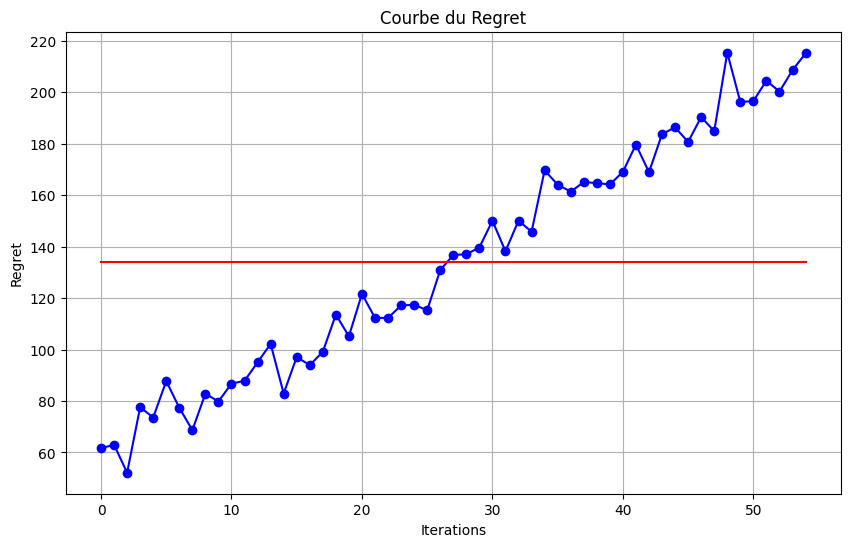

In [55]:
def UCB_regret_N_M():
    eps = 1

    regrets_total = []
    
    MABs = [generate_arms(K) for i in range(1)]
    n = K
    m = N+M

    while n <= m:
        regret = UCB(MABs, n, m, eps, C=2)
        n += K
        m -= K
        regrets_total.append(regret)
    
    return regrets_total

regrets_UCB_SizeN = UCB_regret_N_M()
plot_regret(regrets_UCB_SizeN)

**Réponse**  
N > 0 indique la taille du training set N (nombre de vaccins dans la phase d'exploration).  
Ici, en appliquant l'algorithme UCB, les vacins les moins représentés sont forcés à être testé, ce qui rend inutile la phase d'exploration (les informations des différents vaccins sont constamment mis à jour).   
La phase d"exploration est donc inutile

**Q11. Testez différentes valeurs pour $C$ et trouvez sa valeur optimale expérimentalement.**

In [54]:
def UCB_C():
    eps = 1
    regrets_total = []

    MABs = [generate_arms(K) for i in range(100)]
    Cs = [0, 0.1, 0.5, 1, 2, 5, 10]

    for c in Cs:
        regret = UCB(MABs, 0, N+M, eps, C=c)
        regrets_total.append(np.mean(regret))
    
    min_index = regrets_total.index(min(regrets_total))
    print (f'La meilleur valeur de C pour N = 0 et M={N+M}, est de C={Cs[min_index]} avec un regret moyen de {regrets_total[min_index]}')

UCB_C()

La meilleur valeur de C pour N = 0 et M=550, est de C=0.1 avec un regret moyen de 8.787976264953613


# Echantillonnage de Thomson

Cet algorithme propose de modéliser la variable aléatoire de chaque vaccin avec une loi $\beta$ dont les paramètres $a$ et $b$ correspondent au nombre de patients que le vaccin a immunisés (resp. non immunisés).

Pour chaque patient, on tire un valeur aléatoire pour la loi $\beta$ décrivant chaque vaccin, puis on choisit le vaccin avec la plus grande valeur tirée. 

**Q12. Implémentez cet algorithme. En testant plusieurs valeurs de $N$, montrez que la phase d'exploration précédente a un impact très limité. Cela veut-il dire que l'algorithme ne contient pas d'initialisation ?**

In [185]:
from torch.distributions import Beta

def Thompson_sampling(MAB, n):
    # Initialisation
    alpha = torch.ones(K)
    beta = torch.ones(K)
    rewards = []
    
    # Phase d'exploration
    for _ in range(n):
        samples = torch.tensor([Beta(alpha[i], beta[i]).sample() for i in range(K)])
        chosen_arm = torch.argmax(samples).item()
        reward = MAB[chosen_arm].sample(1).item()
        
        # Mise à jour des paramètres α et β pour le bras sélectionné
        alpha[chosen_arm] += reward
        beta[chosen_arm] += 1 - reward
        rewards.append(reward)
    
    # Phase d'exploitation
    for _ in range(M):
        samples = torch.tensor([Beta(alpha[i], beta[i]).sample() for i in range(K)])
        chosen_arm = torch.argmax(samples).item()
        reward = MAB[chosen_arm].sample(1).item()
        
        # Mise à jour des paramètres α et β pour le bras sélectionné
        alpha[chosen_arm] += reward
        beta[chosen_arm] += 1 - reward
        rewards.append(reward)

    # Calcul du regret
    best_arm = getBestVaccin(MAB)
    regret = (n + M) * MAB[best_arm].immunity_rate - sum(rewards)
    
    return regret

# Test de l'algorithme sur plusieurs instances
def test_Thompson_sampling(n_values=[0, 20, 50, 100]):
    regrets = {}
    for n in n_values:
        regrets_n = []
        for _ in range(number_MAB):
            MAB = generate_arms(K)
            regret = Thompson_sampling(MAB, n)
            regrets_n.append(regret)
        regrets[n] = regrets_n
    
    return regrets

# Tester avec différentes valeurs de N
regrets_Thompson = test_Thompson_sampling(n_values=[0, 20, 50, 100])

# Comparaison des performances
for n, regret in regrets_Thompson.items():
    print(f"N = {n}, Moyenne du regret: {np.mean(regret)}, Écart-type du regret: {np.std(regret)}")


KeyboardInterrupt: 

**Q13. Tracez sous la forme d'une animation l'évolution des taux d'immunisation empirique (fig. de gauche) et l'évolution du regret (fig. droite). Dans la figure de gauche, vous representerez le taux d'immunisation empirique  pour chaque vaccin avec un [graphique en violon](https://en.wikipedia.org/wiki/Violin_plot) qui représente la loi beta associée à chaque vaccin.**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from torch.distributions import Beta

K = 5 
M = 500  
N = 50  

def Thompson_sampling_with_tracking(MAB, n):
    alpha = torch.ones(K)
    beta = torch.ones(K)
    rewards = []
    regret_history = []
    mu_hat_history = []
    
    best_arm = getBestVaccin(MAB)
    
    for _ in range(n):
        samples = torch.tensor([Beta(alpha[i], beta[i]).sample() for i in range(K)])
        chosen_arm = torch.argmax(samples).item()
        reward = MAB[chosen_arm].sample(1).item()
        alpha[chosen_arm] += reward
        beta[chosen_arm] += 1 - reward
        rewards.append(reward)
        
        mu_hat = alpha / (alpha + beta)
        mu_hat_history.append(mu_hat.clone().detach())
        

        regret = (n + M) * MAB[best_arm].immunity_rate - sum(rewards)
        regret_history.append(regret)
    

    for _ in range(M):
        samples = torch.tensor([Beta(alpha[i], beta[i]).sample() for i in range(K)])
        chosen_arm = torch.argmax(samples).item()
        reward = MAB[chosen_arm].sample(1).item()
        alpha[chosen_arm] += reward
        beta[chosen_arm] += 1 - reward
        rewards.append(reward)
        
        mu_hat = alpha / (alpha + beta)
        mu_hat_history.append(mu_hat.clone().detach())
        
        regret = (n + M) * MAB[best_arm].immunity_rate - sum(rewards)
        regret_history.append(regret)
    
    return alpha, beta, mu_hat_history, regret_history

MAB = generate_arms(K)


alpha, beta, mu_hat_history, regret_history = Thompson_sampling_with_tracking(MAB, N)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.set_title("Taux d'immunisation empirique (\u03BC_i) et \u03B2(\u03B1_i, \u03B2_i)")
ax1.set_xlabel("Vaccins")
ax1.set_ylabel("Taux d'immunisation")

ax2.set_title("Évolution du regret")
ax2.set_xlabel("Itération")
ax2.set_ylabel("Regret")

def update(frame):
    ax1.clear()
    ax2.clear()

    data = [Beta(alpha[i], beta[i]).sample((1000,)).numpy() for i in range(K)]
    ax1.violinplot(data, showmeans=True, showmedians=True)
    
    ax1.plot(np.arange(1, K + 1), mu_hat_history[frame], 'r--o', label="Taux empiriques (\u03BC_i)")
    ax1.set_ylim(0, 1)

    ax1.legend()

    ax2.plot(regret_history[:frame], 'b-')
    ax2.set_xlim(0, len(regret_history))
    ax2.set_ylim(0, max(regret_history))

ani = FuncAnimation(fig, update, frames=len(mu_hat_history), interval=200, repeat=False)

In [ ]:
# Peut prendre un peu de temps
ani.save("figures/animation.mp4")
display(HTML(ani.to_jshtml()))

**Q14. Comparez le regret avec les autres algorithmes.**

In [ ]:
def plot_regret(regrets_Thompsont, regret, UCB_regret):

    plt.figure(figsize=(10, 6))
    plt.plot(regrets_Thompson, marker='o', linestyle='-', color='b')
    plt.plot(regret, marker='o', linestyle='-', color='r')
    plt.plot(UCB_regret, marker='o', linestyle='-', color='r')

    plt.xlabel('Itération')
    plt.ylabel('Regret')
    plt.title('Comparaison des différents Regrets')

    plt.grid(True)
    plt.show()

*[Ajoutez votre commentaire ici]*

# Conclusion

**Q15. Calculez le regret des algorithmes glouton, UCB & Thomson lorsqu'il y a un grand nombre de vaccins disponibles (K=100) (on prendra N=100). Faites le lien avec la [malédiction de la dimension](https://fr.wikipedia.org/wiki/Fl%C3%A9au_de_la_dimension).**

In [ ]:
import numpy as np
import torch
from torch.distributions import Beta

# Constants
K = 100  # Number of arms (vaccines)
N = 100  # Exploration patients
M = 1000  # Exploitation patients

# Fonction pour générer les vaccins (bras) avec des probabilités d'immunisation aléatoires
def generate_arms(num_arms: int):
    means = torch.rand(num_arms)
    MAB = [ArmBernoulli(m) for m in means]
    return MAB

# Fonction pour calculer le regret
def calculate_regret(MAB, rewards, best_arm_index, n_total):
    best_immunity_rate = MAB[best_arm_index].immunity_rate
    regret = (n_total * best_immunity_rate) - sum(rewards)
    return regret

# Calculer correctement le regret pour l'algorithme glouton
def glouton(MAB, n=N, m=M):
    exploration_rewards = []
    
    # Phase d'exploration : tester chaque vaccin de manière égale
    for i in range(K):
        rewards = MAB[i].sample(n // K)
        exploration_rewards.extend(rewards.tolist())
    
    # Trouver le meilleur vaccin selon la phase d'exploration
    avg_rewards = [sum(exploration_rewards[i * (n // K):(i + 1) * (n // K)]) / (n // K) for i in range(K)]
    best_arm = np.argmax(avg_rewards)
    
    # Phase d'exploitation : administrer le meilleur vaccin
    exploitation_rewards = MAB[best_arm].sample(m)
    
    # Total des récompenses obtenues
    total_rewards = exploration_rewards + exploitation_rewards.tolist()
    
    # Calcul du regret : n+m représente le nombre total de patients
    best_arm_rate = MAB[best_arm].immunity_rate
    regret = (n + m) * MAB[best_arm].immunity_rate - sum(total_rewards)
    
    return regret


# Algorithme UCB
def UCB(MAB, n=N, m=M, C=2):
    Ti = np.zeros(K)  # Nombre de fois où chaque bras a été sélectionné
    rewards = np.zeros(K)  # Récompenses totales pour chaque bras
    total_rewards = []
    
    # Phase d'exploration initiale : jouer chaque bras au moins une fois
    for i in range(K):
        result = MAB[i].sample(1).item()
        rewards[i] += result
        Ti[i] += 1
        total_rewards.append(result)
    
    # Phase d'exploitation/exploration équilibrée
    for t in range(n, n + m):
        UCB_values = [rewards[i] / Ti[i] + np.sqrt(C * np.log(t + 1) / Ti[i]) for i in range(K)]
        best_arm = np.argmax(UCB_values)
        result = MAB[best_arm].sample(1).item()
        rewards[best_arm] += result
        Ti[best_arm] += 1
        total_rewards.append(result)
    
    best_arm = np.argmax(rewards / Ti)
    regret = calculate_regret(MAB, total_rewards, best_arm, n + m)
    return regret

# Algorithme Thompson Sampling
def Thompson_sampling(MAB, n=N, m=M):
    alpha = torch.ones(K)
    beta = torch.ones(K)
    total_rewards = []
    
    # Phase d'exploration/exploitation via échantillonnage de la loi beta
    for _ in range(n + m):
        samples = torch.tensor([Beta(alpha[i], beta[i]).sample() for i in range(K)])
        chosen_arm = torch.argmax(samples).item()
        reward = MAB[chosen_arm].sample(1).item()
        total_rewards.append(reward)
        alpha[chosen_arm] += reward
        beta[chosen_arm] += 1 - reward
    
    best_arm = getBestVaccin(MAB)
    regret = calculate_regret(MAB, total_rewards, best_arm, n + m)
    return regret


In [ ]:
# Tester chaque algorithme avec K = 100 vaccins

# Générer les vaccins
MAB = generate_arms(K)

# Calcul du regret pour l'algorithme glouton
regret_glouton = glouton(MAB, n=N, m=M)
print(f"Regret glouton avec K=100: {regret_glouton}")

# Calcul du regret pour l'algorithme UCB
regret_UCB = UCB(MAB, n=N, m=M)
print(f"Regret UCB avec K=100: {regret_UCB}")

# Calcul du regret pour l'algorithme Thompson Sampling
regret_Thompson = Thompson_sampling(MAB, n=N, m=M)
print(f"Regret Thompson Sampling avec K=100: {regret_Thompson}")


**Réponse**  
La malédiction de la dimension désigne le phénomène où l'augmentation du nombre de dimensions rend le problème exponentiellement plus difficile. Cela s'applique directement ici pour plusieurs raisons :

Lorsque le nombre de vaccins K est élevé, chaque algorithme doit explorer davantage pour identifier le meilleur vaccin.
Pour les algorithmes glouton et UCB, le coût de l'exploration initiale augmente car il faut tester chaque vaccin plus souvent pour avoir suffisamment de données fiables. Cela entraîne une croissance rapide du regret.
Thompson Sampling est relativement robuste à cette malédiction grâce à sa nature bayésienne, mais il reste sensible au grand nombre de bras, car les échantillons des distributions bêta deviennent plus incertains avec un nombre élevé de bras et moins d'observations.
En résumé, plus K est grand, plus le temps nécessaire pour trouver le meilleur vaccin augmente, ce qui entraîne une hausse du regret, en particulier pour les algorithmes gloutons et UCB.